Pour ce projet presente une implementation d'un modèle de forêt aléatoire sur un ensemble de données contenant des attributs descriptifs d’images numérisées d’un processus connu sous le nom d’aspiration à l’aiguille fine (FNA) de la masse mammaire.

Nous avons un total de 29 caractéristiques qui ont été calculées pour chaque noyau cellulaire avec un numéro d’identification et le diagnostic (converti plus tard en représentations binaires: malin = 1, bénin = 0).

In [1]:
# Import modules
%matplotlib inline

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from urllib.request import urlopen 

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500) 

# Load Data

In [2]:
#load the data into a Pandas dataframe
breast_cancer = pd.read_csv("https://raw.githubusercontent.com/chaimaesal/ML_Essalama_Chaimae/main/data.csv")
names = ['id', 'diagnosis', 'radius_mean', 
         'texture_mean', 'perimeter_mean', 'area_mean', 
         'smoothness_mean', 'compactness_mean', 
         'concavity_mean','concave_points_mean', 
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se', 
         'area_se', 'smoothness_se', 'compactness_se', 
         'concavity_se', 'concave_points_se', 
         'symmetry_se', 'fractal_dimension_se', 
         'radius_worst', 'texture_worst', 
         'perimeter_worst', 'area_worst', 
         'smoothness_worst', 'compactness_worst', 
         'concavity_worst', 'concave_points_worst', 
         'symmetry_worst', 'fractal_dimension_worst'] 

dx = ['Benign', 'Malignant']

# Cleaning

In [3]:
#Nous effectuons un nettoyage mineur, comme la définition de id_number comme
#index de la trame de données, ainsi que la conversion du diagnostic 
#en représentation binaire standard 1, 0 à l'aide de la fonction map().
# Setting 'id_number' as our index
breast_cancer.set_index(['id'], inplace = True) 
# Converted to binary to help later on with models and plots
breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map({'M':1, 'B':0})

# Missing Values

In [4]:
#exécution une méthode apply utilisant une expression lambda qui vérifie
#s’il y avait des valeurs manquantes dans chaque colonne. 
#Impression itérative du nom de la colonne et des valeurs totales manquantes 
#pour cette colonne.
breast_cancer.apply(lambda x: x.isnull().sum())

diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32                569
dtype: i

In [6]:
# For later use in CART models
names_index = names[2:]

In [8]:
#Ce code suivant sera utilisé pour le modèle de forêt aléatoire,
#où le id_number ne sera pas pertinent. supprimons la colonne supplémentaire
del breast_cancer['Unnamed: 32']

KeyError: 'Unnamed: 32'

In [9]:
#Prévisualisons l’ensemble de données à l’aide de la fonction head() qui donnera les 5 premières valeurs
breast_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
print("la dimension de data frame:\n", 
     breast_cancer.shape)
print("le data types de colonnes:\n",
     breast_cancer.dtypes)

la dimension de data frame:
 (569, 31)
le data types de colonnes:
 diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst      

# Class Imbalance

In [13]:
#Pour s'assurer que nos classes cibles ne sont pas déséquilibrées, 
#on cree une fonction qui produira la distribution des classes cibles.
def print_dx_perc(data_frame, col):
    """Function used to print class distribution for our data set"""
    try:
        # Stores value counts
        col_vals = data_frame[col].value_counts()
        # Resets index to make index a column in data frame
        col_vals = col_vals.reset_index()
        # If the number of unique instances in column exceeds 20 print warning
        if len(col_vals['index']) > 20:
            print('Warning: values in column are more than 20 \nPlease try a column with lower value counts!')
        # Else it calculates/prints percentage for each unique value in column
        else:
            # Create a function to output the percentage
            f = lambda x, y: 100 * (x / sum(y))
            for i in range(0, len(col_vals['index'])):
                 print('{0} accounts for {1:.2f}% of the {2} column'\
                      .format(col_vals['index'][i],
                              f(col_vals[col].iloc[i],
                                col_vals[col]),
                              col))
    # try-except block goes here if it can't find the column in data frame
    except KeyError as e:
        print('{0}: Not found'.format(e))
        print('Please choose the right column name!')

In [14]:
print_dx_perc(breast_cancer, 'diagnosis')

0 accounts for 62.74% of the diagnosis column
1 accounts for 37.26% of the diagnosis column


cet ensemble de données ne souffre pas d’un d'éséquilibre de classe.

In [15]:
#la fonction describe donne des statistiques descriptives standard pour chaque caractéristique, 
#y compris la moyenne, l’écart-type, la valeur minimale, la valeur maximale et 
#les intervalles de plage.
breast_cancer.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


# Creating Training and Test Sets

Divisons l’ensemble de données en nos ensembles de formation et de test, qui seront sélectionnés pseudo-aléatoirement pour créer une répartition de 80 à 20%. 
on utilise l’ensemble de formation pour entraîner le modèle et effectuer une optimisation. on utilise l’ensemble de tests, qui agira comme des données invisibles, pour évaluer les performances du modèle.
Lorsque on utilise cette méthode pour l’apprentissage automatique, faut toujours de l’utilisation de l'ensemble de tests pour créer des modèles. La fuite de données est un problème courant qui peut entraîner un surajustement

In [16]:
feature_space = breast_cancer.iloc[:, breast_cancer.columns != 'diagnosis']
feature_class = breast_cancer.iloc[:, breast_cancer.columns == 'diagnosis']


training_set, test_set, class_set, test_class_set = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.20, 
                                                                    random_state = 42)

In [17]:
# Cleaning test sets to avoid future warning messages
class_set = class_set.values.ravel() 
test_class_set = test_class_set.values.ravel() 

# Fitting Random Forest

Maintenant, créons le modèle, en commençant par le réglage des paramètres.  :

max_depth: Les fractionnements maximums pour tous les arbres de la forêt. bootstrap : Un indicateur indiquant si nous voulons ou non utiliser des échantillons bootstrap lors de la construction d’arbres.
        
max_features: Le nombre maximal de fonctionnalités qui seront utilisées dans le fractionnement de nœud - 
critère : Il s’agit de la métrique utilisée pour établir les critères d’arrêt des arbres de décision.


In [18]:
# Set the random state for reproducibility
fit_rf = RandomForestClassifier(random_state=42)

# Hyperparameters Optimization¶

En utilisant la fonctionnalité GridSearchCV, créons un dictionnaire avec des paramètres que nous cherchons à optimiser pour créer le meilleur modèle pour nos données. Définir la n_jobs sur 3 indique à la recherche de grille d’exécuter trois tâches en parallèle, ce qui réduit le temps que la fonction prendra pour calculer les meilleurs paramètres. on a inclus la minuterie pour voir combien de temps les différents travaux prenaient; cela m’a finalement amené à décider d’utiliser trois emplois parallèles.
Cela aidera à définir les paramètres que nous utiliserons pour régler un dernier paramètre: le nombre d’arbres dans notre forêt.

In [23]:
np.random.seed(42)
start = time.time()

param_dist = {'max_depth': [2, 3, 4],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(fit_rf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv_rf.fit(training_set, class_set)
print('Best Parameters using grid search: \n', 
      cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2'}
Time taken in grid search:  32.57


In [24]:
# Set best parameters given by grid search 
fit_rf.set_params(criterion = 'entropy',
                  max_features = 'log2', 
                  max_depth = 4)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                       random_state=42)

# Out of Bag Error Rate

Une autre caractéristique utile de la forêt aléatoire est le concept d’un taux d’erreur out-of-bag (OOB). Étant donné que seulement les deux tiers des données sont utilisées pour entraîner chaque arbre lors de la construction de la forêt, un tiers des données invisibles peuvent être utilisées d’une manière avantageuse pour nos mesures de précision sans être aussi coûteuses en calcul que quelque chose comme la validation croisée, 

In [25]:
fit_rf.set_params(warm_start=True, 
                  oob_score=True)

min_estimators = 15
max_estimators = 1000

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    fit_rf.set_params(n_estimators=i)
    fit_rf.fit(training_set, class_set)

    oob_error = 1 - fit_rf.oob_score_
    error_rate[i] = oob_error

In [26]:
# Convert dictionary to a pandas series for easy plotting 
oob_series = pd.Series(error_rate)

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

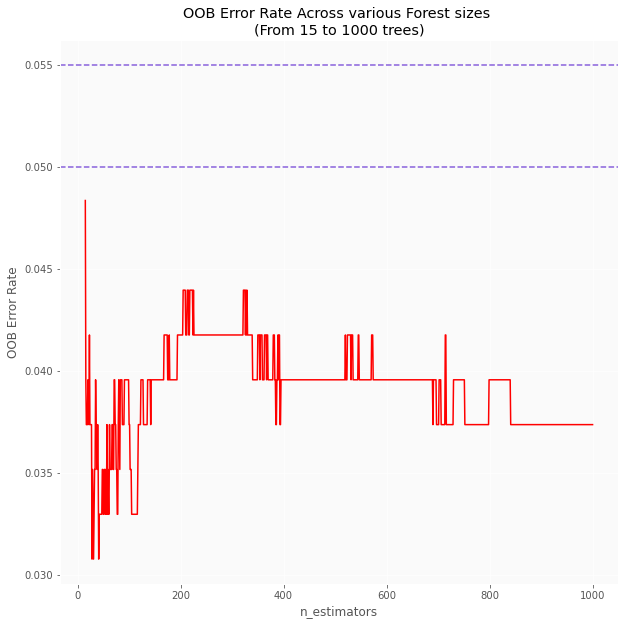

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',
                color = 'red')
plt.axhline(0.055, 
            color='#875FDB',
           linestyle='--')
plt.axhline(0.05, 
            color='#875FDB',
           linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

Le taux d’erreur OOB commence à s’osciler à environ 400 arbres, alors on vas aller de l’avant et utiliser 400 arbres dans la forêt. En utilisant l’objet de la série pandas, on peut facilement trouver le taux d’erreur OOB pour l’estimateur comme suit:

In [28]:
print('OOB Error rate for 400 trees is: {0:.5f}'.format(oob_series[400]))

OOB Error rate for 400 trees is: 0.03956


L’utilisation du taux d’erreur OOB qui a été créé avec le modèle nous donne un taux d’erreur impartial. Étant donné que l’OOB peut être calculé avec l’estimation du modèle, il est utile lorsque la validation croisée et / ou l’optimisation des hyperparamètres s’avèrent trop coûteuses sur le plan informatique.

on va passé revue d’autres méthodes traditionnelles d’optimisation des modèles d’apprentissage automatique, y compris la route d’erreur de formation et de test et les métriques de validation croisée.


# Traditional Training and Test Set Split

Pour que cette méthodologie fonctionne, nous allons définir le nombre d’arbres calculés à l’aide du taux d’erreur OOB et supprimer les paramètres warm_start et oob_score. En plus d’inclure le paramètre bootstrap.

In [29]:
fit_rf.set_params(n_estimators=400,
                  bootstrap = True,
                  warm_start=False, 
                  oob_score=False)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                       n_estimators=400, random_state=42)

# Training Algorithm

Next we train the algorithm utilizing the training and target class set we had made earlier.

In [30]:
fit_rf.fit(training_set, class_set)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                       n_estimators=400, random_state=42)

# Variable Importance

In [33]:
def variable_importance(fit):
    """
    Purpose
    ----------
    Checks if model is fitted CART model then produces variable importance
    and respective indices in dictionary.

    Parameters
    ----------
    * fit:  Fitted model containing the attribute feature_importances_

    Returns
    ----------
    Dictionary containing arrays with importance score and index of columns
    ordered in descending order of importance.
    """
    try:
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Captures whether the model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        print("Model entered does not contain 'estimators_' attribute.")

    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [38]:
var_imp_rf = variable_importance(fit_rf)

importances_rf = var_imp_rf['importance']

indices_rf = var_imp_rf['index']

In [39]:
def print_var_importance(importance, indices, name_index):
    """
    Purpose
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on information gain for CART model.
    Parameters
    ----------
    * importance: Array returned from feature_importances_ for CART
                models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest
                based on feature_importances_
    * name_index: Name of columns included in model

    Returns
    ----------
    Prints feature importance in descending order
    """
    print("Feature ranking:")
    for f in range(0, indices.shape[0]):
        i = f
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1,
                      names_index[indices[i]],
                      importance[indices[f]]))

In [40]:
print_var_importance(importances_rf, indices_rf, names_index)

Feature ranking:
1. The feature 'area_worst' has a Mean Decrease in Impurity of 0.12603
2. The feature 'perimeter_worst' has a Mean Decrease in Impurity of 0.11260
3. The feature 'concave_points_worst' has a Mean Decrease in Impurity of 0.11156
4. The feature 'concave_points_mean' has a Mean Decrease in Impurity of 0.09233
5. The feature 'radius_worst' has a Mean Decrease in Impurity of 0.07561
6. The feature 'concavity_mean' has a Mean Decrease in Impurity of 0.05808
7. The feature 'area_mean' has a Mean Decrease in Impurity of 0.04866
8. The feature 'concavity_worst' has a Mean Decrease in Impurity of 0.04826
9. The feature 'radius_mean' has a Mean Decrease in Impurity of 0.04690
10. The feature 'perimeter_mean' has a Mean Decrease in Impurity of 0.04466
11. The feature 'area_se' has a Mean Decrease in Impurity of 0.04033
12. The feature 'texture_worst' has a Mean Decrease in Impurity of 0.02461
13. The feature 'compactness_worst' has a Mean Decrease in Impurity of 0.01990
14. The fe

In [45]:
def variable_importance_plot(importance, indices, name_index):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart
    was transposed and index would be in incorrect order.

    Parameters
    ----------
    * importance: Array returned from feature_importances_ for CART
                models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest
                based on feature_importances_
    * name_index: Name of columns included in model

    Returns:
    ----------
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index))
    importance_desc = sorted(importance)
    feature_space = []
    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_facecolor('#fafafa')
    plt.title('Feature importances for Random Forest Model\
    \nBreast Cancer (Diagnostic)')
    plt.barh(index,
             importance_desc,
             align="center",
             color = '#875FDB')
    plt.yticks(index,
               feature_space)

    plt.ylim(-1, 30)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Impurity')
    plt.ylabel('Feature')
    plt.show()
    plt.close()

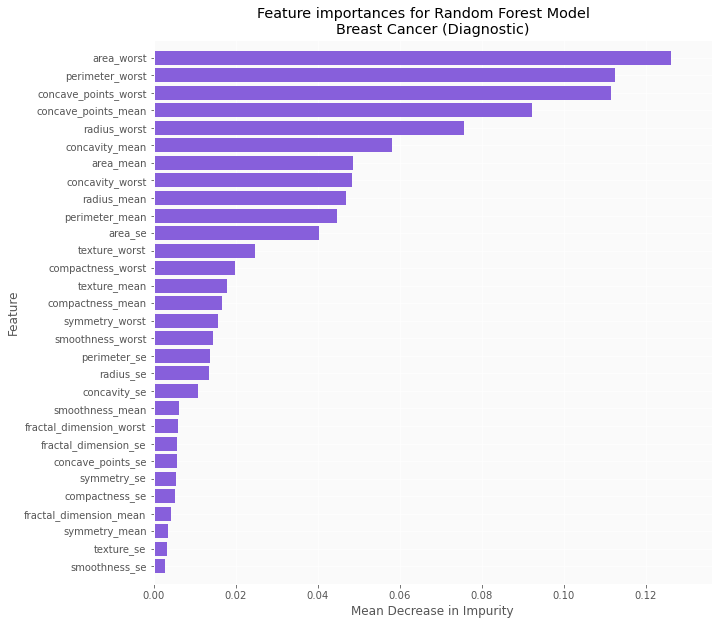

In [46]:
variable_importance_plot(importances_rf, indices_rf, names_index)

Le visuel ci-dessus aide à faire comprendre le point, car on peut clairement voir la différence dans l’importance des variables pour la méthode d’ensemble. Certains points de coupure peuvent être faits pour réduire l’inclusion de fonctionnalités et peuvent aider à la précision du modèle, car nous supprimerons ce qui est considéré comme du bruit dans notre espace de fonctionnalités.

# K-Fold Cross Validation

Ici, nous utilisons la validation croisée K-fold; plus précisément, 10 plis. Nous créons 10 sous-ensembles de nos données sur lesquels utiliser la méthodologie de formation et d’ensemble de tests; ensuite, nous ferons la moyenne de la précision pour tous les plis pour nous donner notre estimation.



In [47]:
def cross_val_metrics(fit, training_set, class_set, estimator, print_results = True):
    """
    Purpose
    ----------
    Function helps automate cross validation processes while including 
    option to print metrics or store in variable

    Parameters
    ----------
    fit: Fitted model 
    training_set:  Data_frame containing 80% of original dataframe
    class_set:     data_frame containing the respective target vaues 
                      for the training_set
    print_results: Boolean, if true prints the metrics, else saves metrics as 
                      variables

    Returns
    ----------
    scores.mean(): Float representing cross validation score
    scores.std() / 2: Float representing the standard error (derived
                from cross validation score's standard deviation)
    """
    my_estimators = {
    'rf': 'estimators_',
    'nn': 'out_activation_',
    'knn': '_fit_method'
    }
    try:
        # Captures whether first parameter is a model
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Captures whether the model has been trained
        if not vars(fit)[my_estimators[estimator]]:
            return print("Model does not appear to be trained.")
    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
\nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    n = KFold(n_splits=10)
    scores = cross_val_score(fit, 
                         training_set, 
                         class_set, 
                         cv = n)
    if print_results:
        for i in range(0, len(scores)):
            print("Cross validation run {0}: {1: 0.3f}".format(i, scores[i]))
        print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})"\
              .format(scores.mean(), scores.std() / 2))
    else:
        return scores.mean(), scores.std() / 2

In [48]:
cross_val_metrics(fit_rf, 
                  training_set, 
                  class_set, 
                  'rf',
                  print_results = True)

Cross validation run 0:  1.000
Cross validation run 1:  0.957
Cross validation run 2:  0.935
Cross validation run 3:  0.935
Cross validation run 4:  0.957
Cross validation run 5:  0.978
Cross validation run 6:  0.978
Cross validation run 7:  0.933
Cross validation run 8:  1.000
Cross validation run 9:  0.933
Accuracy:  0.960 (+/-  0.013)


# Test Set Metrics

À l’aide de l’ensemble de tests créé précédemment, examinons une autre mesure pour l’évaluation de notre modèle

In [49]:
predictions_rf = fit_rf.predict(test_set)

#Confusion Matrix
Ici, nous créons une matrice de confusion visuelle avec seaborn et transposons la matrice lors de la création de la carte thermique.

In [50]:
def create_conf_mat(test_class_set, predictions):
    """Function returns confusion matrix comparing two arrays"""
    if (len(test_class_set.shape) != len(predictions.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (test_class_set.shape != predictions.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = test_class_set,
                                        columns = predictions)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

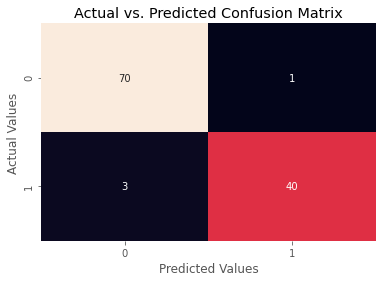

In [51]:
conf_mat = create_conf_mat(test_class_set, predictions_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [52]:
accuracy_rf = fit_rf.score(test_set, test_class_set)

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_rf))

Here is our mean accuracy on the test set:
 0.965


In [53]:
# Here we calculate the test error rate!
test_error_rate_rf = 1 - accuracy_rf
print("The test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_rf))

The test error rate for our model is:
  0.0351


on remarque, nous avons obtenu un taux d’erreur très similaire pour notre ensemble de tests que nous avons fait pour notre OOB, ce qui est un bon signe pour notre modèle.

# ROC Curve Metrics

In [54]:
# We grab the second array from the output which corresponds to
# to the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class
predictions_prob = fit_rf.predict_proba(test_set)[:, 1]

fpr2, tpr2, _ = roc_curve(test_class_set,
                          predictions_prob,
                          pos_label = 1)

In [55]:
auc_rf = auc(fpr2, tpr2)

In [57]:
def plot_roc_curve(fpr, tpr, auc, estimator, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph

    Parameters
    ----------
    * fpr: Array returned from sklearn.metrics.roc_curve for increasing
            false positive rates
    * tpr: Array returned from sklearn.metrics.roc_curve for increasing
            true positive rates
    * auc: Float returned from sklearn.metrics.auc (Area under Curve)
    * estimator: String represenation of appropriate model, can only contain the
    following: ['knn', 'rf', 'nn']
    * xlim: Set upper and lower x-limits
    * ylim: Set upper and lower y-limits
    """
    my_estimators = {'knn': ['Kth Nearest Neighbor', 'deeppink'],
              'rf': ['Random Forest', 'red'],
              'nn': ['Neural Network', 'purple']}

    try:
        plot_title = my_estimators[estimator][0]
        color_value = my_estimators[estimator][1]
    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
\nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
             color=color_value,
             linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f})'\
              .format(plot_title, auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()

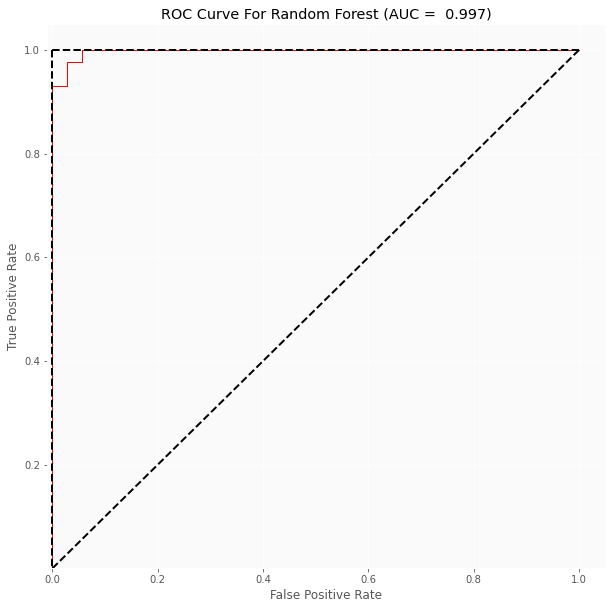

In [58]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

Notre modèle a fait exceptionnel avec une ASC supérieure à 0,90, maintenant nous faisons une vue zoomée pour montrer la proximité de notre courbe ROC par rapport à la courbe ROC idéale.

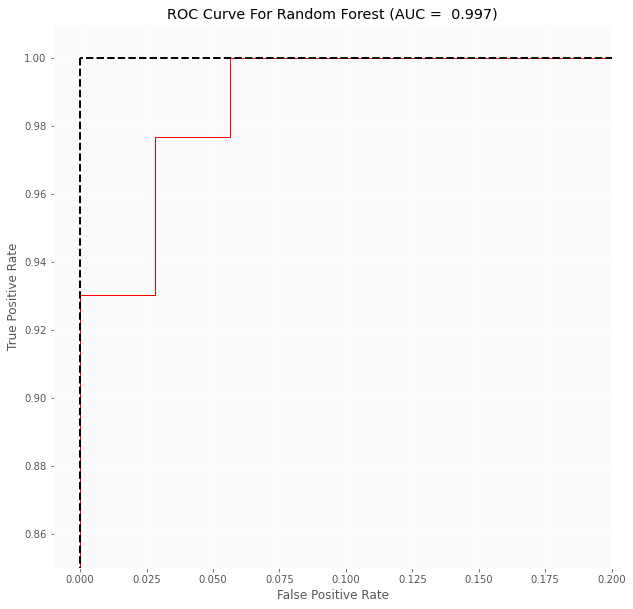

In [59]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf', 
               xlim=(-0.01, 0.2), 
               ylim=(0.85, 1.01))

# Classification Report

In [60]:
def print_class_report(predictions, alg_name):
    """
    Purpose
    ----------
    Function helps automate the report generated by the
    sklearn package. Useful for multiple model comparison

    Parameters:
    ----------
    predictions: The predictions made by the algorithm used
    alg_name: String containing the name of the algorithm used
    
    Returns:
    ----------
    Returns classification report generated from sklearn. 
    """
    print('Classification Report for {0}:'.format(alg_name))
    print(classification_report(predictions, 
            test_class_set, 
            target_names = dx))

In [61]:
class_report = print_class_report(predictions_rf, 'Random Forest')

Classification Report for Random Forest:
              precision    recall  f1-score   support

      Benign       0.99      0.96      0.97        73
   Malignant       0.93      0.98      0.95        41

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



# Metrics for Random Forest

Here I've accumulated the various metrics we used through this tutorial in a simple table! Showcasing the power and effectiveness of Random Forest Modeling.

Model	       OOB Error Rate	  Test Error Rate	Cross Validation Score	AUC
Random Forest  0.04835	          0.0351	         0.947 (+/- 0.019)	  0.967